In [1]:
import matplotlib as mpl

font = {'family' : 'sans',
        'size'   : 12}

mpl.rc('font', **font)

import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import glob
from cmcrameri import cm
from matplotlib.ticker import MultipleLocator

In [7]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# %matplotlib widget

In [8]:
F_sun = 1.3608e3
folder = "data/article_data/mnras_proteus_agni/"

In [9]:
selsis_data = np.loadtxt(folder+"plots/valid/selsis/OTR10000.txt")
sel_P = selsis_data.T[0] * 1e-5
sel_T = selsis_data.T[6]
sel_s0 = 35.6
sel_al = 0.18

In [10]:
def get_agni_ncdfs(fo):

    agni_ncdfs = glob.glob(fo+"/*.nc")

    agni_data = []
    for p in agni_ncdfs:
        ds = nc.Dataset(p)
        d = {}
        for k in ds.variables.keys():
            d[k] = ds.variables[k][:]
        agni_data.append(d)
        ds.close()

    mask = [float(ds["instellation"]) for ds in agni_data]
    mask = np.argsort(mask)

    agni_arr = []
    inst_arr = []
    for i in mask:
        agni_arr.append(agni_data[i])
        inst_arr.append(agni_data[i]["instellation"]/F_sun)

    return agni_arr, inst_arr

AGNI 15.0 1783.1 1643.3
AGNI 25.0 1915.8 1751.0
SELS 35.6 1966.2
AGNI 35.0 2001.4 1821.7
AGNI 45.0 2063.9 1874.4


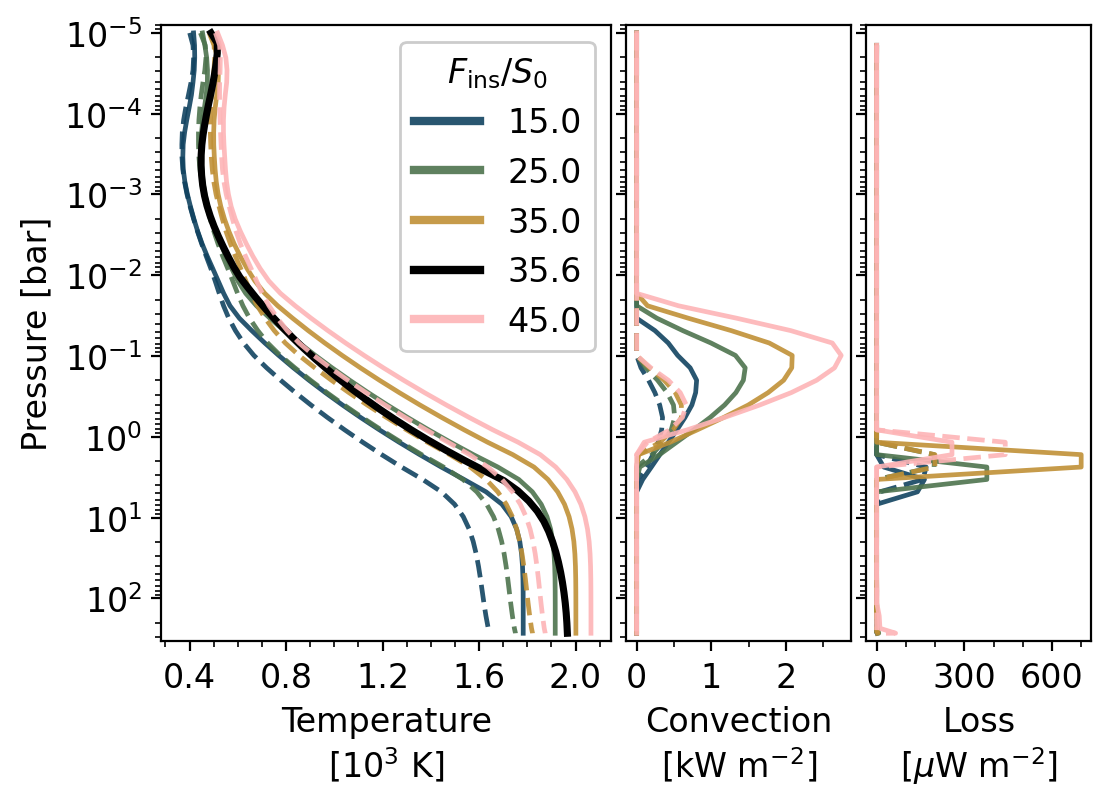

In [15]:
lw = 1.7
al = 0.9

ff_agni, ff_inst = get_agni_ncdfs(folder+"plots/valid/frostflow256")
oa_agni, oa_inst = get_agni_ncdfs(folder+"plots/valid/oak318")

norm = mpl.colors.Normalize(vmin=np.amin(ff_inst), vmax=np.amax(ff_inst))
sm = plt.cm.ScalarMappable(cmap=cm.batlow, norm=norm)
sm.set_array([])

fig,axs = plt.subplots(1,3, figsize=(6,4), width_ratios=[2, 1, 1], sharey=True)
axl = axs[0]
axc = axs[1]
axr = axs[2]

idxs = list(range(1, len(ff_agni), 2))

# plot agni outputs
for i in idxs:

    ins = ff_inst[i]
    col = sm.to_rgba(ins)

    # Get data
    oa = oa_agni[i]
    ff = ff_agni[i]
    y_arr = oa["pl"]*1e-5

    # Albedos
    alb_ff   = ff["fl_U_SW"][0]/ff["fl_D_SW"][0]
    alb_oa   = oa["fl_U_SW"][0]/oa["fl_D_SW"][0]

    # Temperatures
    axl.plot(oa["tmpl"]/1e3, y_arr, c=col, ls='dashed', alpha=al, lw=lw)
    lbl = "%.1f"%ins
    axl.plot(ff["tmpl"]/1e3, y_arr, c=col, ls='solid', alpha=al, label=lbl, lw=lw)
    lbl = None

    axc.plot(oa["fl_cnvct"] / 1e3, y_arr, c=col, ls='dashed', alpha=al, lw=lw)
    axc.plot(ff["fl_cnvct"] / 1e3, y_arr, c=col, ls='solid', alpha=al, lw=lw)

    # Flux loss
    x_arr = oa["fl_tot"] * 1e6
    x_arr = np.abs(x_arr[1:] - x_arr[:-1])
    axr.plot(x_arr, y_arr[1:], c=col, ls='dashed', alpha=al, lw=lw)

    x_arr = ff["fl_tot"] * 1e6
    x_arr = np.abs(x_arr[1:] - x_arr[:-1])
    axr.plot(x_arr, y_arr[1:], c=col, ls='solid', alpha=al, lw=lw)

    # Calculate albedos

    # plot selsis?
    if i < len(ff_inst)-1:
        if (ff_inst[i+1] > sel_s0 > ff_inst[i]):
            axl.plot(sel_T/1e3, sel_P, label="%.1f"%sel_s0, color='k', lw=lw*1.5)
            print("SELS %.1f %.1f"%(sel_s0, sel_T[-1]))

    print("AGNI %.1f %.1f %.1f"%(ins, ff["tmp_surf"], oa["tmp_surf"]))

leg = axl.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0), framealpha=1.0, title=r"$F_\text{ins}/S_0$")
for line in leg.get_lines():
    line.set_linewidth(3.0)

axl.set_ylim(top=1e-5*0.8, bottom=270/0.8)
axl.set_yscale("log")
axl.set_xlabel("Temperature\n" + r"[$10^3$ K]")
axl.set_ylabel("Pressure [bar]")
axl.xaxis.set_major_locator(MultipleLocator(0.4))
axl.xaxis.set_minor_locator(MultipleLocator(0.1))

axc.set_xlabel("Convection\n"+r"[kW m$^{-2}$]")
axc.xaxis.set_major_locator(MultipleLocator(1))
axc.xaxis.set_minor_locator(MultipleLocator(0.5))

axr.set_xlabel("Loss\n"+r"[$\mu$W m$^{-2}$]")
axr.xaxis.set_major_locator(MultipleLocator(300))
axr.xaxis.set_minor_locator(MultipleLocator(100))

# for i,c in enumerate(["a","b","c"]):
#     ax = axs[i]
#     ax.text(0.02, 0.01, "(%s)"%c, fontsize=14,
#             backgroundcolor=(1.0,1.0,1.0,0.1),
#             horizontalalignment='left', verticalalignment='bottom', transform = ax.transAxes)

fig.align_xlabels()

fig.subplots_adjust(wspace=0.05)

fig.savefig("output/selsis_compare.pdf", bbox_inches='tight')